Implement a 1D CNN-based classifier to capture temporal dependencies within the eye movement traces

In [16]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, Input, Model
from sklearn.model_selection import train_test_split

In [17]:
# Data loading function
def load_trace_data(csv_dir, max_length=1000):
    X, y = [], []
    for file in os.listdir(csv_dir):
        if not file.endswith('.csv'):
            continue
        file_path = os.path.join(csv_dir, file)
        df = pd.read_csv(file_path)

        # abs_lx, abs_ly, abs_rx, abs_ry
        if {'abs_lx', 'abs_ly', 'abs_rx', 'abs_ry'}.issubset(df.columns):
            trace = df[['abs_lx', 'abs_ly', 'abs_rx', 'abs_ry']].values.astype(np.float32)
        else:
            trace = df.iloc[:, 1:5].values.astype(np.float32)

        # Pad or truncate
        if len(trace) >= max_length:
            trace = trace[:max_length]
        else:
            trace = np.pad(trace, ((0, max_length - len(trace)), (0, 0)), mode='constant')

        # 0,2 -> label 0; 1,3 -> label 1
        if '_0' in file or '_2' in file:
            label = 0
        elif '_1' in file or '_3' in file:
            label = 1
        else:
            continue

        X.append(trace)
        y.append(label)

    return np.array(X), np.array(y)


Original length + padding

In [26]:
import os
import numpy as np
import pandas as pd

def load_trace_data_original(csv_dir):
    X, y, lengths = [], [], []

    # First determine the longest sequence length
    max_len = 0
    for file in os.listdir(csv_dir):
        if file.endswith('.csv'):
            file_path = os.path.join(csv_dir, file)
            df = pd.read_csv(file_path)
            seq_len = len(df)
            max_len = max(max_len, seq_len)
            lengths.append(seq_len)

    print(f"Max sequence length detected: {max_len}")

    # Second traversal, loading and padding
    for file in os.listdir(csv_dir):
        if not file.endswith('.csv'):
            continue
        file_path = os.path.join(csv_dir, file)
        df = pd.read_csv(file_path)

        try:
            if {'abs_lx', 'abs_ly', 'abs_rx', 'abs_ry'}.issubset(df.columns):
                trace = df[['abs_lx', 'abs_ly', 'abs_rx', 'abs_ry']].values.astype(np.float32)
            else:
                trace = df.iloc[:, 1:5].values.astype(np.float32)
        except Exception as e:
            print(f"Skipping {file} due to error: {e}")
            continue

        # pad to max_len
        if len(trace) < max_len:
            trace = np.pad(trace, ((0, max_len - len(trace)), (0, 0)), mode='constant')

        X.append(trace)

        # Label：0,2 → 0；1,3 → 1
        label = 0 if any(x in file for x in ['_0', '_2']) else 1
        y.append(label)

    return np.array(X), np.array(y), max_len


In [19]:
# Model building
def build_1dcnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(32, 7, activation='relu', name='conv1d_1')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, activation='relu', name='conv1d_2')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [20]:
import numpy as np
import tensorflow as tf

def gradcam_1d(model, sample, label_index=0, layer_name='conv1d', verbose=False):
    """
    Generate GradCAM++ heatmap for a 1D input sample.
    
    Args:
        model: Trained tf.keras.Model (Functional API required)
        sample: 2D array of shape (T, F), e.g. (1000, 4)
        label_index: Target class index (0 for binary)
        layer_name: Name of the convolutional layer to compute gradients for
        verbose: If True, print debug information
    Returns:
        1D heatmap array of length T (same time dimension as input)
    """
    try:
        grad_model = tf.keras.models.Model(
            [model.inputs],
            [model.get_layer(layer_name).output, model.output]
        )

        inputs = tf.cast(sample[None, ...], tf.float32)  # shape: (1, T, F)

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, label_index]

        grads = tape.gradient(loss, conv_outputs)[0]  # shape: (T', C)
        pooled_grads = tf.reduce_mean(grads, axis=0)  # shape: (C,)
        conv_outputs = conv_outputs[0]  # shape: (T', C)

        heatmap = tf.reduce_sum(tf.multiply(conv_outputs, pooled_grads), axis=-1)
        heatmap = tf.nn.relu(heatmap).numpy()

        # Normalise safely
        if np.max(heatmap) > 0:
            heatmap /= np.max(heatmap)
        else:
            if verbose:
                print("GradCAM heatmap is all zero.")
            heatmap = np.zeros_like(heatmap)

        if verbose:
            print("GradCAM debug info:")
            print("Prediction:", predictions.numpy())
            print("Conv output shape:", conv_outputs.shape)
            print("Grads max:", np.max(grads.numpy()), "mean:", np.mean(grads.numpy()))
            print("Heatmap max:", np.max(heatmap), "min:", np.min(heatmap))

        return heatmap

    except Exception as e:
        print(f"Error in GradCAM computation: {e}")
        return np.zeros(sample.shape[0])  # fallback: empty heatmap


In [21]:
def segment_heatmap(heatmap, n_segments=3):
    """
    Divide a heatmap into segments (start/middle/end) and compute average heat per segment.
    """
    length = len(heatmap)
    seg_len = length // n_segments
    segment_means = []
    for i in range(n_segments):
        start = i * seg_len
        end = (i + 1) * seg_len if i < n_segments - 1 else length
        segment_means.append(np.mean(heatmap[start:end]))
    return segment_means  # e.g., [start_mean, mid_mean, end_mean]


In [22]:
# Visualisation function
def plot_trace_with_heatmap(trace, heatmap, title="GradCAM++", save_path=None):
    plt.figure(figsize=(12, 4))
    plt.plot(trace[:, 0], label='abs_lx', alpha=0.6)
    plt.plot(trace[:, 2], label='abs_rx', alpha=0.6)
    plt.fill_between(range(len(heatmap)), 0, heatmap, color='red', alpha=0.3, label='GradCAM++ Importance')
    plt.title(title)
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [23]:
def clean_trace_data(X):
    return np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

In [8]:
# Path setting and training
csv_path = '/Users/wukehui/Desktop/data science project/project/data/first_trials'
# Loading raw data
X, y = load_trace_data(csv_path, max_length=1500)


# Clean the entire X
X = clean_trace_data(X)
X = X / 960.0  # Data Standardisation

nan_count = np.isnan(X).sum()
print(f"Total NaN count in dataset: {nan_count}")
if nan_count > 5:
    print("Warning: Too many NaN values, check data preprocessing.")

# Then divide the training/validation set
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


#model = build_1dcnn_model(input_shape=(1000, 4))
#model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Total NaN count in dataset: 0


In [27]:
csv_path = '/Users/wukehui/Desktop/data science project/project/data/first_trials'

# Loading raw length data + padding
X, y, max_len = load_trace_data_original(csv_path)
print(f"X shape: {X.shape}, y shape: {y.shape}, max_length used: {max_len}")

# Data cleaning + standardisation
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
X = X / 960.0

Max sequence length detected: 40800
X shape: (196, 40800, 4), y shape: (196,), max_length used: 40800


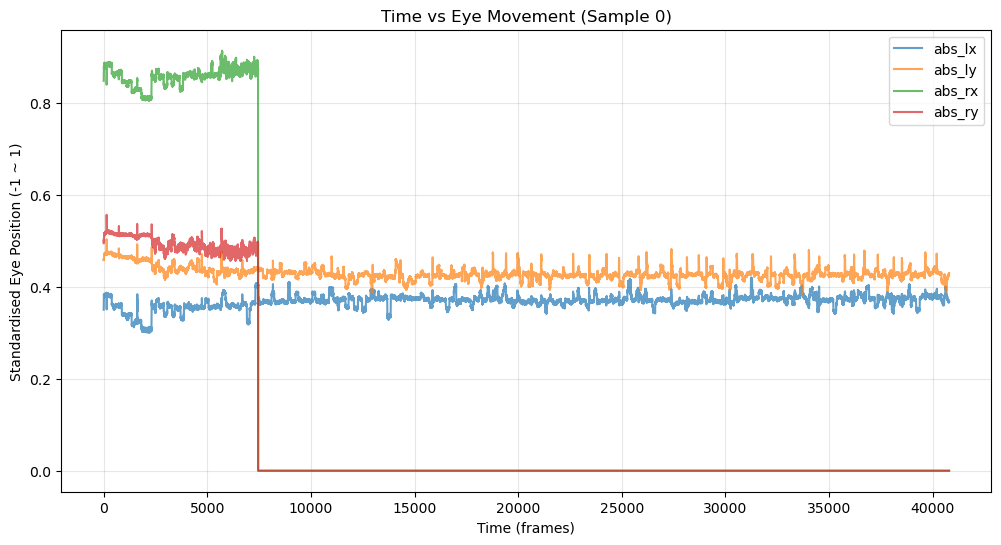

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_time_series(X, sample_idx=0):
    """
    Draw a time vs lx/ly/rx/ry graph for a given sample
    Args:
        X: numpy array, shape (n_samples, time_steps, 4)
        sample_idx: the index of the sample to be drawn
    """
    trace = X[sample_idx]
    time = np.arange(trace.shape[0])  # 0 ~ max_length-1

    plt.figure(figsize=(12, 6))
    plt.plot(time, trace[:, 0], label="abs_lx", alpha=0.7)
    plt.plot(time, trace[:, 1], label="abs_ly", alpha=0.7)
    plt.plot(time, trace[:, 2], label="abs_rx", alpha=0.7)
    plt.plot(time, trace[:, 3], label="abs_ry", alpha=0.7)

    plt.title(f"Time vs Eye Movement (Sample {sample_idx})")
    plt.xlabel("Time (frames)")
    plt.ylabel("Standardised Eye Position (-1 ~ 1)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Draw the 0th sample
plot_time_series(X, sample_idx=0)


In [29]:
from sklearn.model_selection import train_test_split

def split_by_participant(X, y, test_size=0.3, random_state=42):
    participants = [f.split('_')[0] for f in os.listdir(csv_path) if f.endswith('.csv')]
    unique_ids = list(set(participants))
    
    # Divide the participants
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size, random_state=random_state)

    X_train, y_train, X_val, y_val = [], [], [], []
    for file, xi, yi in zip(os.listdir(csv_path), X, y):
        pid = file.split('_')[0]
        if pid in train_ids:
            X_train.append(xi)
            y_train.append(yi)
        else:
            X_val.append(xi)
            y_val.append(yi)
    return np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val)

X_train, X_val, y_train, y_val = split_by_participant(X, y)


In [12]:
# Cleaning Data
#X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
#X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)

# Retrain the model
model = build_1dcnn_model((1000, 4))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5564 - loss: 0.6906 - val_accuracy: 0.4754 - val_loss: 0.6932
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4727 - loss: 0.6942 - val_accuracy: 0.4918 - val_loss: 0.6934
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4799 - loss: 0.6952 - val_accuracy: 0.4918 - val_loss: 0.6934
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4857 - loss: 0.6961 - val_accuracy: 0.4754 - val_loss: 0.6934
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5118 - loss: 0.6910 - val_accuracy: 0.4754 - val_loss: 0.6934
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5150 - loss: 0.6922 - val_accuracy: 0.4754 - val_loss: 0.6934
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4367 - loss: 0.6956 - val_accuracy: 0.4754 - val_loss: 0.6935
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5170 - loss: 0.6950 - val_accuracy: 0.4754 - val_loss: 0.6936


In [30]:
# Retrain the model
model = build_1dcnn_model((max_len, 4))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.5065 - loss: 0.6963 - val_accuracy: 0.5082 - val_loss: 0.6944
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.5279 - loss: 0.6922 - val_accuracy: 0.5082 - val_loss: 0.6938
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.5097 - loss: 0.6976 - val_accuracy: 0.5410 - val_loss: 0.6933
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.4561 - loss: 0.6953 - val_accuracy: 0.5246 - val_loss: 0.6929
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.4539 - loss: 0.6939 - val_accuracy: 0.4754 - val_loss: 0.6925
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.4875 - loss: 0.6933 - val_accuracy: 0.4754 - val_loss: 0.6922
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.4784 - loss: 0.6922 - val_accuracy: 0.4754 - val_loss: 0.6920
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.4939 - loss: 0.6913 - val_accuracy: 0.4754 - val_loss:

In [31]:
# Use the model to make predictions, and the output is the probability value
y_pred_prob = model.predict(X_val)
# If the output is sigmoid (binary classification), the probability is greater than 0.5 and is judged as 1, otherwise it is 0
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Validation Accuracy: 0.4754


Error in GradCAM computation: No such layer: conv1d. Existing layers are: ['input_layer_1', 'conv1d_1', 'max_pooling1d_1', 'conv1d_2', 'global_average_pooling1d_1', 'dense_2', 'dropout_1', 'dense_3'].


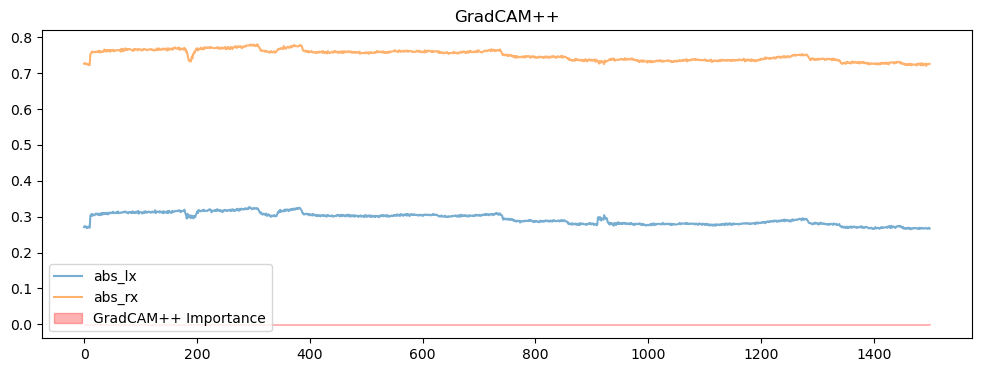

In [14]:
sample = X_val[0]
heatmap = gradcam_1d(model, sample, layer_name='conv1d', verbose=True)
plot_trace_with_heatmap(sample, heatmap)

In [101]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Standardise Input
scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])  # reshape for scaler
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)

X_train, X_val, y_train, y_val = split_data(X_scaled, y)

# Define Optimised 1D CNN Model
def build_improved_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(64, 7, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Conv1D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling1D())

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Train the Model
model = build_improved_model(input_shape=(1000, 4))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/Users/wukehui/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5795 - loss: 0.7935 - val_accuracy: 0.5085 - val_loss: 0.7025
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6566 - loss: 0.6191 - val_accuracy: 0.5932 - val_loss: 0.6973
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7201 - loss: 0.5909 - val_accuracy: 0.5932 - val_loss: 0.6992
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7588 - loss: 0.5447 - val_accuracy: 0.5254 - val_loss: 0.7002
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7513 - loss: 0.5292 - val_accuracy: 0.5085 - val_loss: 0.7014
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7066 - loss: 0.5795 - val_accuracy: 0.5254 - val_loss: 0.6998
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7591 - loss: 0.5443 - val_accuracy: 0.5254 - val_loss: 0.7013
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7470 - loss: 0.4961 - val_accuracy: 0.5254 - val_loss: 0.7060
Epoch 9/50


In [102]:
# Predict and evaluate
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("\n", classification_report(y_val, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Accuracy: 0.5932
F1 Score: 0.4000
ROC AUC: 0.5879

               precision    recall  f1-score   support

           0       0.56      0.90      0.69        30
           1       0.73      0.28      0.40        29

    accuracy                           0.59        59
   macro avg       0.64      0.59      0.55        59
weighted avg       0.64      0.59      0.55        59



Since the model accuracy is low, it is changed to BiLSTM + CNN hybrid model

In [103]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Clean NaNs
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Divide the training set
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

In [105]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 1.0073529411764706, 1: 0.9927536231884058}


In [106]:
from tensorflow.keras.callbacks import EarlyStopping

model = build_bilstm_model(input_shape=(1000, 4))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,  # Add category weights
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/Users/wukehui/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.4780 - loss: 0.7040 - val_accuracy: 0.4576 - val_loss: 0.7004
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.4300 - loss: 0.7026 - val_accuracy: 0.4915 - val_loss: 0.6974
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4892 - loss: 0.6994 - val_accuracy: 0.5085 - val_loss: 0.6947
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5576 - loss: 0.6874 - val_accuracy: 0.5085 - val_loss: 0.6924
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.5745 - loss: 0.6855 - val_accuracy: 0.5254 - val_loss: 0.6904
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5637 - loss: 0.6919 - val_accuracy: 0.5593 - val_loss: 0.6880
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.6039 - loss: 0.6867 - val_accuracy: 0.5932 - val_loss: 0.6859
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6626 - loss: 0.6757 - val_accuracy: 0.6102 - val_loss: 0.6840
Epo

In [107]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("\nDetailed report:\n", classification_report(y_val, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Accuracy: 0.6441
F1 Score: 0.6182
ROC AUC: 0.6431

Detailed report:
               precision    recall  f1-score   support

           0       0.64      0.70      0.67        30
           1       0.65      0.59      0.62        29

    accuracy                           0.64        59
   macro avg       0.65      0.64      0.64        59
weighted avg       0.64      0.64      0.64        59



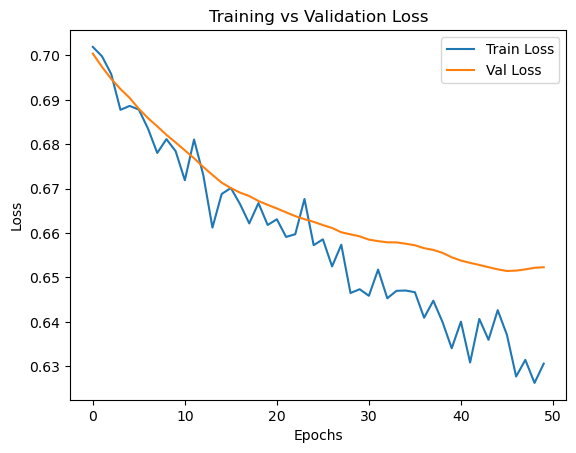

In [108]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Apply Grad-CAM++ to visualise which time steps contributed most to the classification decision

In [50]:
import os
import matplotlib.pyplot as plt

def batch_gradcam_visualisation(model, X_val, y_val, layer_name='conv1d',
                                output_dir='gradcam_vis', n_samples_per_class=5):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'lcl'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'hcl'), exist_ok=True)

    count = {0: 0, 1: 0}
    for idx, (x, y) in enumerate(zip(X_val, y_val)):
        if count[y] >= n_samples_per_class:
            continue
        
        heatmap = gradcam_1d(model, x, layer_name=layer_name)

        # Visualise + Save Image
        plt.figure(figsize=(12, 4))
        plt.plot(x[:, 0], label='abs_lx', alpha=0.6)
        plt.plot(x[:, 2], label='abs_rx', alpha=0.6)
        plt.fill_between(range(len(heatmap)), 0, heatmap, color='red', alpha=0.3, label='GradCAM++ Importance')
        plt.title(f"Sample {idx} | Label: {'LCL' if y==0 else 'HCL'}")
        plt.legend()

        save_path = os.path.join(output_dir, 'lcl' if y == 0 else 'hcl', f'sample_{idx}_label_{y}.png')
        plt.savefig(save_path)
        plt.close()

        count[y] += 1
        print(f"Saved GradCAM++ plot for sample {idx} (label={y}) → {save_path}")

        # If both categories are sufficient, exit early
        if count[0] >= n_samples_per_class and count[1] >= n_samples_per_class:
            break

    print(f"Done! Generated GradCAM++ plots for {count[0]} LCL and {count[1]} HCL samples.")

In [51]:
batch_gradcam_visualisation(model, X_val, y_val, layer_name='conv1d', n_samples_per_class=5)

Saved GradCAM++ plot for sample 0 (label=1) → gradcam_vis/hcl/sample_0_label_1.png
Saved GradCAM++ plot for sample 1 (label=0) → gradcam_vis/lcl/sample_1_label_0.png
Saved GradCAM++ plot for sample 2 (label=1) → gradcam_vis/hcl/sample_2_label_1.png
Saved GradCAM++ plot for sample 3 (label=0) → gradcam_vis/lcl/sample_3_label_0.png
Saved GradCAM++ plot for sample 4 (label=1) → gradcam_vis/hcl/sample_4_label_1.png
Saved GradCAM++ plot for sample 5 (label=1) → gradcam_vis/hcl/sample_5_label_1.png
Saved GradCAM++ plot for sample 6 (label=1) → gradcam_vis/hcl/sample_6_label_1.png
Saved GradCAM++ plot for sample 8 (label=0) → gradcam_vis/lcl/sample_8_label_0.png
Saved GradCAM++ plot for sample 9 (label=0) → gradcam_vis/lcl/sample_9_label_0.png
Saved GradCAM++ plot for sample 10 (label=0) → gradcam_vis/lcl/sample_10_label_0.png
Done! Generated GradCAM++ plots for 5 LCL and 5 HCL samples.


In [53]:
import csv

def save_segment_stats(model, X_val, y_val, layer_name='conv1d', output_csv='heatmap_segment_stats.csv'):
    """
    For each sample in validation set, compute GradCAM++ heatmap, segment it, and save stats to CSV.
    """
    results = []
    for idx, (sample, label) in enumerate(zip(X_val, y_val)):
        heatmap = gradcam_1d(model, sample, layer_name=layer_name)
        if np.sum(heatmap) == 0:
            print(f"⚠️ Heatmap for sample {idx} is empty. Skipping.")
            continue

        start, middle, end = segment_heatmap(heatmap)
        results.append({
            'sample_id': idx,
            'label': int(label),
            'start_mean': start,
            'middle_mean': middle,
            'end_mean': end
        })

    # Save to CSV
    keys = ['sample_id', 'label', 'start_mean', 'middle_mean', 'end_mean']
    with open(output_csv, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=keys)
        writer.writeheader()
        writer.writerows(results)

    print(f"Saved segment heatmap stats for {len(results)} samples to {output_csv}")

In [54]:
save_segment_stats(model, X_val, y_val, layer_name='conv1d')

Saved segment heatmap stats for 59 samples to heatmap_segment_stats.csv


In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and confirm column names
df = pd.read_csv('heatmap_segment_stats.csv')
print(df.columns)

Index(['sample_id', 'label', 'start_mean', 'middle_mean', 'end_mean'], dtype='object')


In [66]:
# Calculate the average heat value of each segment by group
group_means = df.groupby('label')[['start_mean', 'middle_mean', 'end_mean']].mean().reset_index()

# Change label to a string so the legend looks good
group_means['label'] = group_means['label'].map({0: 'LCL', 1: 'HCL'})

In [69]:
print(group_means)

  label  start_mean  middle_mean  end_mean
0   LCL    0.585924     0.517849  0.458971
1   HCL    0.700933     0.647869  0.591371


start_mean → p = 0.0392
middle_mean → p = 0.0249
end_mean → p = 0.0335


/var/folders/z2/m_dpmkln675bnchq3c6kytjh0000gn/T/ipykernel_86197/2161646765.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df_plot, x='segment', y='importance', hue='label', palette='Set2', ci=None)


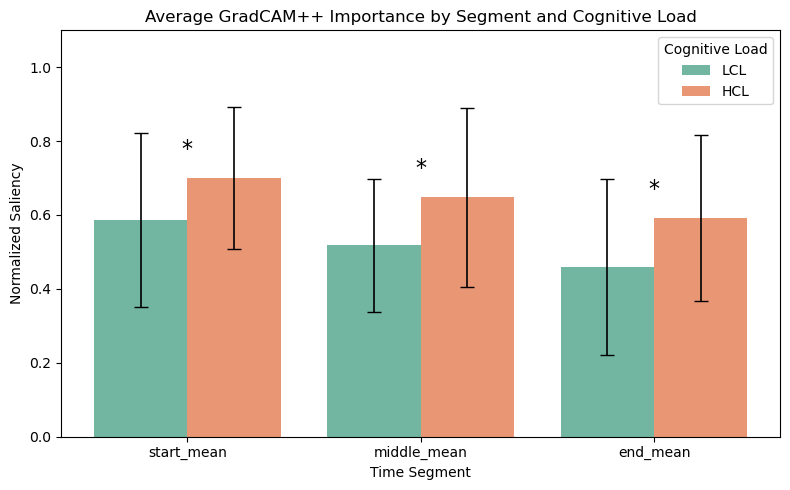

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


# Calculate mean and standard deviation
means = df.groupby('label')[['start_mean', 'middle_mean', 'end_mean']].mean().reset_index()
stds = df.groupby('label')[['start_mean', 'middle_mean', 'end_mean']].std().reset_index()
means['label'] = means['label'].map({0: 'LCL', 1: 'HCL'})
stds['label'] = stds['label'].map({0: 'LCL', 1: 'HCL'})

# Combine mean and standard deviation (for plotting)
df_plot = pd.melt(means, id_vars='label', var_name='segment', value_name='importance')
df_std = pd.melt(stds, id_vars='label', var_name='segment', value_name='std')

df_plot['std'] = df_std['std']

# Drawing
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_plot, x='segment', y='importance', hue='label', palette='Set2', ci=None)
for i, bar in enumerate(ax.patches):
    std = df_plot['std'].iloc[i]
    height = bar.get_height()
    ax.errorbar(
        bar.get_x() + bar.get_width() / 2,
        height,
        yerr=std,
        capsize=5,
        color='black',
        linewidth=1.2
    )

# Statistical significance (t-test)
segments = ['start_mean', 'middle_mean', 'end_mean']
for i, segment in enumerate(segments):
    lcl = df[df['label'] == 0][segment]
    hcl = df[df['label'] == 1][segment]
    stat, p = ttest_ind(lcl, hcl, equal_var=False)
    print(f"{segment} → p = {p:.4f}")
    if p < 0.05:
        # Add a significant annotation (a star above the image)
        x = i
        y_max = max(lcl.mean(), hcl.mean())
        plt.text(x, y_max + 0.06, '*', ha='center', fontsize=16)

plt.title('Average GradCAM++ Importance by Segment and Cognitive Load')
plt.xlabel('Time Segment')
plt.ylabel('Normalized Saliency')
plt.ylim(0, 1.1)
plt.legend(title='Cognitive Load')
plt.tight_layout()
plt.savefig('/Users/wukehui/Desktop/data science project/graph/gradcam_segment_importance_plot.png', dpi=300)
plt.show()


Incorporate SHAP (SHapley Additive exPlanations) to estimate the contribution of each input channel (left/right eye x- and y-coordinates) across all time steps

In [128]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.0/548.0 kB 5.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [76]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.regularizers import l2

def build_shap_friendly_model(input_shape=(1000, 4)):
    inputs = Input(shape=input_shape)

    x = layers.Conv1D(64, 7, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)  # (500, 64)

    x = layers.Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)  # (250, 128)

    x = layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)  # Alternative to Flatten

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [77]:
model = build_shap_friendly_model((1000, 4))
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4965 - loss: 0.9729 - val_accuracy: 0.5000 - val_loss: 0.7511
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6130 - loss: 0.6812 - val_accuracy: 0.5000 - val_loss: 0.8214
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6059 - loss: 0.6875 - val_accuracy: 0.5000 - val_loss: 0.8869
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6220 - loss: 0.6669 - val_accuracy: 0.5000 - val_loss: 1.0428
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5830 - loss: 0.7088 - val_accuracy: 0.5000 - val_loss: 1.0296
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7275 - loss: 0.5922 - val_accuracy: 0.5000 - val_loss: 1.2526
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6406 - loss: 0.6712 - val_accuracy: 0.5000 - val_loss: 2.1929
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6736 - loss: 0.6034 - val_accuracy: 0.5000 - val_loss: 3.4956


In [114]:
import shap

# Select background
background = X_train[np.random.choice(len(X_train), size=30, replace=False)]

# GradientExplainer is currently the most compatible method with Conv1D
explainer = shap.GradientExplainer((model.input, model.output), background)

X_explain = X_val[:5]
shap_values = explainer.shap_values(X_explain)

print("SHAP output shape:", shap_values[0].shape)


/Users/wukehui/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_73
Received: inputs=['Tensor(shape=(5, 1000, 4))']
  warnings.warn(msg)
/Users/wukehui/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_73
Received: inputs=['Tensor(shape=(50, 1000, 4))']
  warnings.warn(msg)


SHAP output shape: (1000, 4, 1)


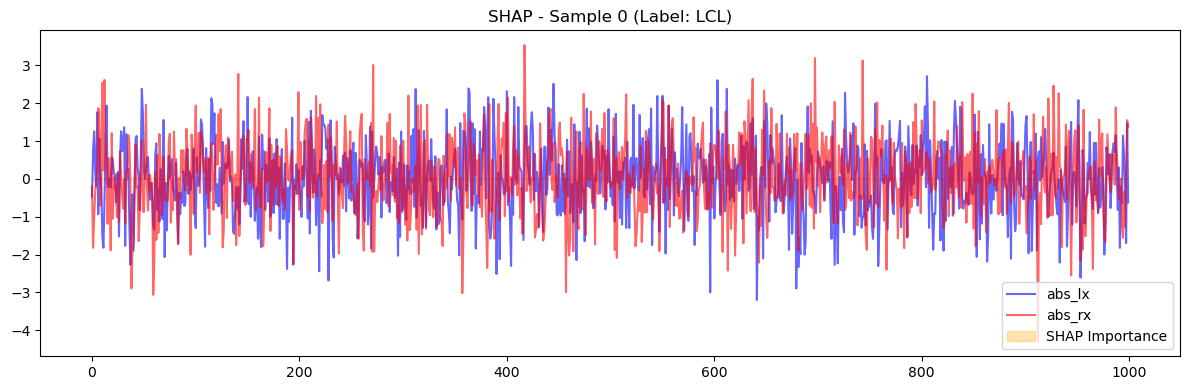

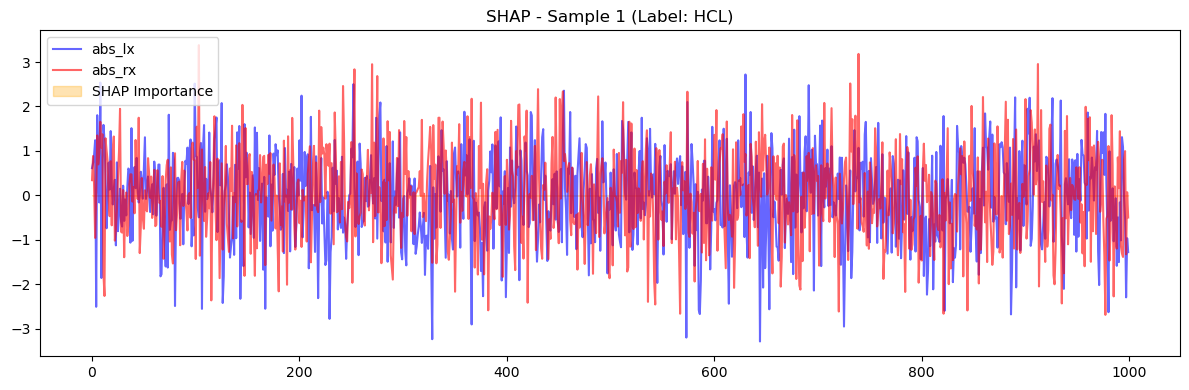

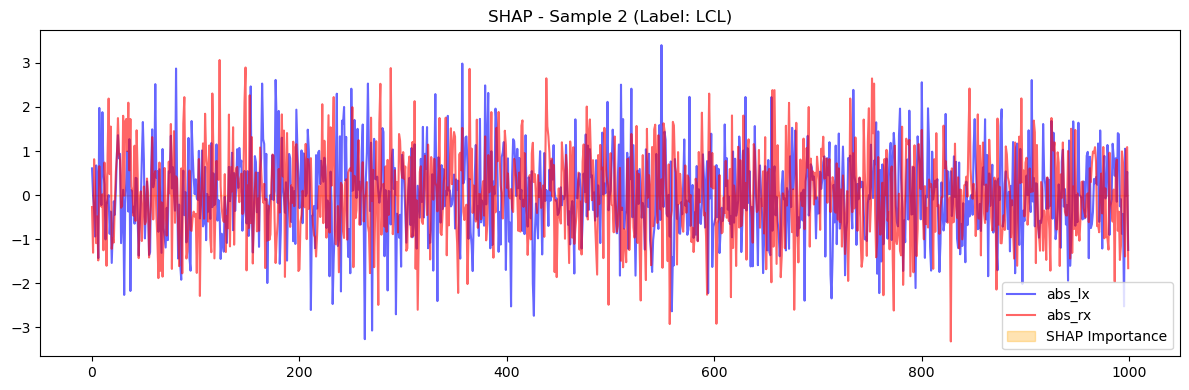

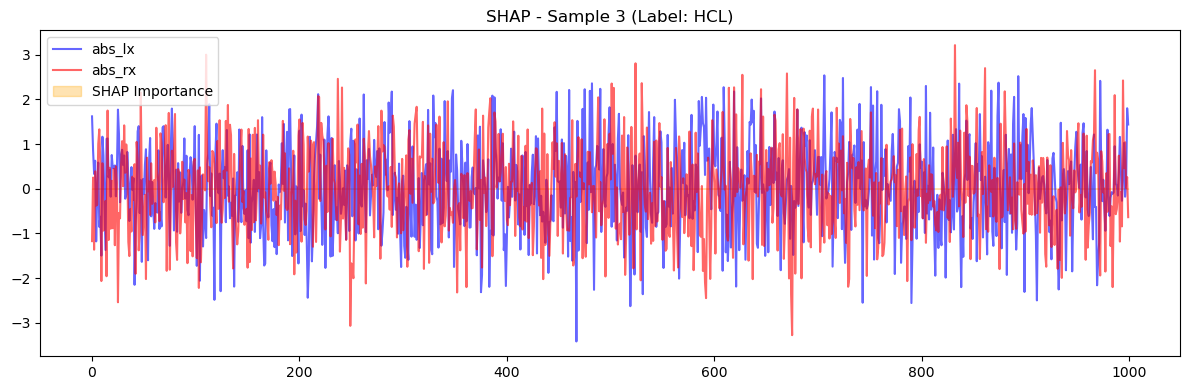

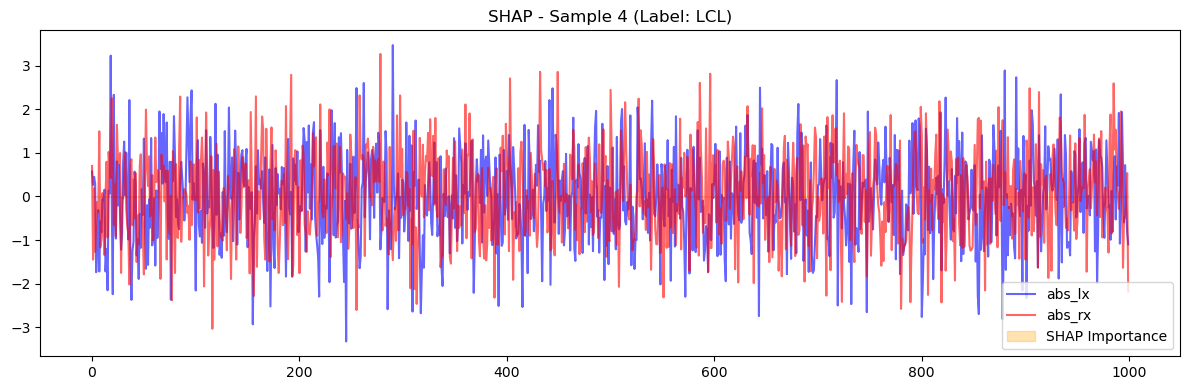

In [115]:
for i in range(len(X_explain)):
    sample = X_explain[i]                  # shape: (1000, 4)
    shap_val = shap_values[i]              # shape: (1000, 4, 1)

    if shap_val.shape != (1000, 4, 1):
        print(f"Skipping sample {i} due to unexpected shape: {shap_val.shape}")
        continue

    # Remove the last dimension and it becomes (1000, 4)
    shap_val = shap_val.squeeze(-1)

    # Find the importance of each time point (calculate the absolute value of the channel and add them up)
    shap_importance = np.abs(shap_val).sum(axis=1)  # shape: (1000,)

    # Drawing
    plt.figure(figsize=(12, 4))
    plt.plot(sample[:, 0], label='abs_lx', color='blue', alpha=0.6)
    plt.plot(sample[:, 2], label='abs_rx', color='red', alpha=0.6)
    plt.fill_between(range(1000), 0, shap_importance, alpha=0.3,
                     color='orange', label='SHAP Importance')
    plt.title(f"SHAP - Sample {i} (Label: {'HCL' if y_val[i]==1 else 'LCL'})")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

shap_values_arr = np.array(shap_values)
shap_segment_results = []

for i in range(len(shap_values_arr)):
    val = shap_values_arr[i]
    if val.shape != (1000, 4, 1):
        print(f"Skipping sample {i} due to unexpected shape: {val.shape}")
        continue

    shap_val = val.squeeze(-1)                     # (1000, 4)
    shap_importance = np.abs(shap_val).sum(axis=1) # (1000,)
    seg_len = 1000 // 3
    start = np.mean(shap_importance[:seg_len])
    middle = np.mean(shap_importance[seg_len:2*seg_len])
    end = np.mean(shap_importance[2*seg_len:])
    
    shap_segment_results.append({
        'label': 'HCL' if y_val[i] == 1 else 'LCL',
        'start_mean': start,
        'middle_mean': middle,
        'end_mean': end
    })

# Convert to DataFrame
shap_segment_results = pd.DataFrame(shap_segment_results)

# t-test analysis
start_p = ttest_ind(
    shap_df[shap_df['label']=='HCL']['start_mean'],
    shap_df[shap_df['label']=='LCL']['start_mean'],
    equal_var=False
).pvalue
middle_p = ttest_ind(
    shap_df[shap_df['label']=='HCL']['middle_mean'],
    shap_df[shap_df['label']=='LCL']['middle_mean'],
    equal_var=False
).pvalue
end_p = ttest_ind(
    shap_df[shap_df['label']=='HCL']['end_mean'],
    shap_df[shap_df['label']=='LCL']['end_mean'],
    equal_var=False
).pvalue

# Organise data for plotting
means = shap_df.groupby('label').mean().reset_index()
stds = shap_df.groupby('label').std().reset_index()
melted = pd.melt(means, id_vars='label', var_name='segment', value_name='mean')
std_melted = pd.melt(stds, id_vars='label', var_name='segment', value_name='std')
merged = pd.merge(melted, std_melted, on=['label', 'segment'])

# Significant symbol
p_map = {'start_mean': start_p, 'middle_mean': middle_p, 'end_mean': end_p}
merged['significance'] = merged['segment'].map(lambda s: '*' if p_map[s] < 0.05 else '')



Segmented SHAP Importance Summary:
  label  start_mean  middle_mean  end_mean
0   LCL    0.001557     0.001494  0.001590
1   HCL    0.001470     0.001423  0.001499
2   LCL    0.001281     0.001258  0.001305
3   HCL    0.001703     0.001695  0.001782
4   LCL    0.001745     0.001733  0.001834


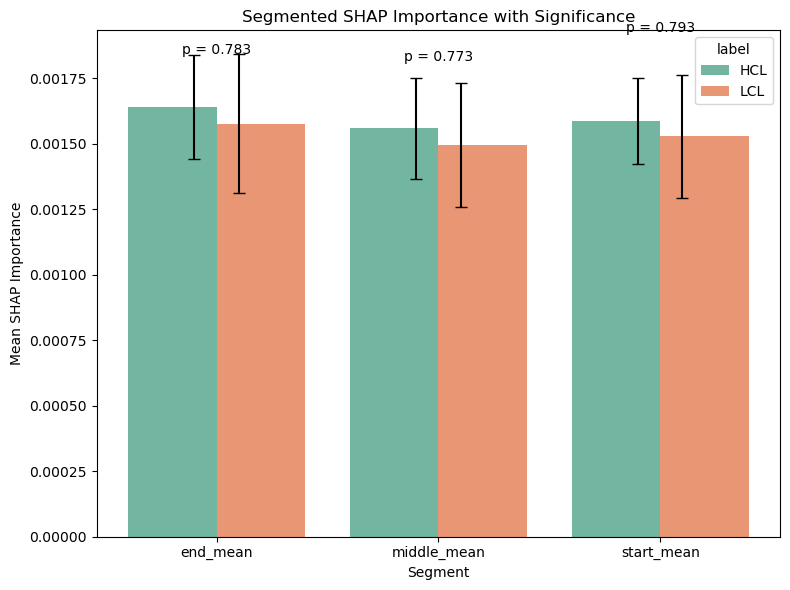

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


# Convert to DataFrame
df_shap = pd.DataFrame(shap_segment_results)

# Show summary
print("Segmented SHAP Importance Summary:")
print(df_shap)

# Convert to long format
shap_long = df_shap.melt(id_vars='label', var_name='segment', value_name='importance')

# Calculate the mean and standard deviation
summary = shap_long.groupby(['segment', 'label'])['importance'].agg(['mean', 'std']).reset_index()

# Draw a bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=summary, x='segment', y='mean', hue='label', palette='Set2', capsize=0.2)

# Add error bars
for i, row in summary.iterrows():
    x_pos = i // 2 + (i % 2 - 0.5) * 0.2
    ax.errorbar(x=x_pos, y=row['mean'], yerr=row['std'], fmt='none', c='black', capsize=4)

# Add significance markers and p-values
segments = df_shap.columns.drop('label')
for i, seg in enumerate(segments):
    lcl = df_shap[df_shap['label'] == 'LCL'][seg]
    hcl = df_shap[df_shap['label'] == 'HCL'][seg]
    stat, p = ttest_ind(lcl, hcl)
    #x1, x2 = i - 0.2, i + 0.2
    #ax.plot([x1, x1, x2, x2], [y, y+0.01, y+0.01, y], lw=1.5, c='k')
    # Move up more to avoid occlusion
    segment_summary = summary[summary['segment'] == seg]
    y_max = segment_summary['mean'].max()
    y_err = segment_summary['std'].max()
    y = y_max + y_err + 0.00001  # Adjustable pan range

    ax.text(i, y, f"p = {p:.3f}", ha='center', va='bottom', fontsize=10)


# Graphics beautification
plt.title("Segmented SHAP Importance with Significance")
plt.ylabel("Mean SHAP Importance")
plt.xlabel("Segment")
plt.tight_layout()
plt.show()



Because the test result was not significant, the sample size was increased to 100.

In [122]:
import numpy as np
import pandas as pd
import shap
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Build the interpreter (unchanged)
background = X_train[np.random.choice(len(X_train), size=100, replace=False)]
explainer = shap.DeepExplainer((model.input, model.output), background)

# Select sample (expand to 100)
np.random.seed(42)
selected_idx = np.random.choice(len(X_val), size=100, replace=True)
X_explain = X_val[selected_idx]
y_explain = y_val[selected_idx]

# SHAP Analysis + Paragraph Attribution
shap_values = explainer.shap_values(X_explain)
print("SHAP output shape:", shap_values[0].shape)  # Should be (100, 1000, 4)

segment_shap_results = []

for i in range(len(X_explain)):
    sample = X_explain[i]                     # (1000, 4)
    label = y_explain[i]                      # 0 or 1
    shap_val = shap_values[i]                 # (1000, 4, 1) or (1000, 4)

    if shap_val.shape[-1] == 1:
        shap_val = shap_val.squeeze(-1)       # (1000, 4)

    if shap_val.shape != (1000, 4):
        print(f"Skipping sample {i} due to unexpected shape: {shap_val.shape}")
        continue

    shap_importance = np.abs(shap_val).sum(axis=1)  # shape: (1000,)

    s, m, e = np.split(shap_importance, [333, 667])
    segment_result = {
        'label': 'HCL' if label == 1 else 'LCL',
        'start': s.mean(),
        'middle': m.mean(),
        'end': e.mean()
    }
    segment_shap_results.append(segment_result)

# Convert to DataFrame
df_shap = pd.DataFrame(segment_shap_results)
print("Segment-wise SHAP DataFrame created:")
display(df_shap.head())


/Users/wukehui/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/wukehui/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_73
Received: inputs=['Tensor(shape=(100, 1000, 4))']
  warnings.warn(msg)
/Users/wukehui/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_73
Received: inputs=['Tensor(shape=(200, 1000, 4))']
  warnings.warn(msg)


SHAP output shape: (1000, 4, 1)
Segment-wise SHAP DataFrame created:


,label,start,middle,end
0,LCL,0.001360,0.001339,0.001329
1,HCL,0.001367,0.001343,0.001334
2,HCL,0.001365,0.001336,0.001324
3,LCL,0.001360,0.001338,0.001316
4,LCL,0.001360,0.001339,0.001329


/var/folders/z2/m_dpmkln675bnchq3c6kytjh0000gn/T/ipykernel_3943/1269535228.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data=melted, x='segment', y='importance', hue='label', ci='sd', capsize=0.1)


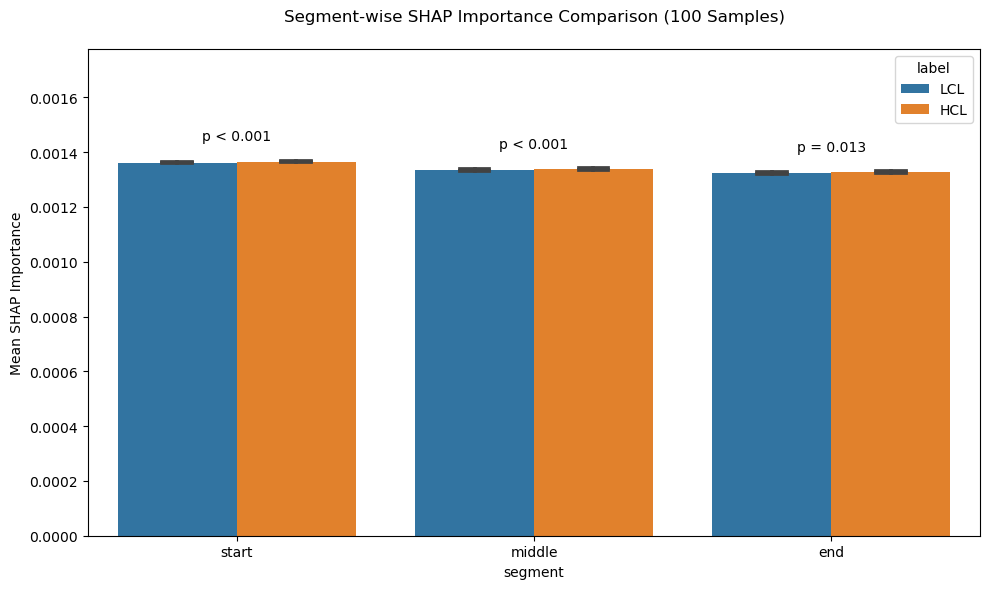

In [123]:
# Melt construct for seaborn
melted = df_shap.melt(id_vars='label', value_vars=['start', 'middle', 'end'],
                      var_name='segment', value_name='importance')

# Grouped t-test
lcl = df_shap[df_shap['label'] == 'LCL'][['start', 'middle', 'end']]
hcl = df_shap[df_shap['label'] == 'HCL'][['start', 'middle', 'end']]
p_values = {seg: ttest_ind(lcl[seg], hcl[seg], equal_var=False).pvalue for seg in ['start', 'middle', 'end']}

# Drawing
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=melted, x='segment', y='importance', hue='label', ci='sd', capsize=0.1)
ax.set_ylim(0, melted['importance'].max() * 1.3)

# Add p-value text
segment_order = ['start', 'middle', 'end']
for i, seg in enumerate(segment_order):
    bar_heights = melted[melted['segment'] == seg].groupby('label')['importance'].mean()
    y = bar_heights.max() * 1.05
    p = p_values[seg]
    text = f"p = {p:.3f}" if p >= 0.001 else "p < 0.001"
    ax.text(i, y, text, ha='center', va='bottom', fontsize=10, color='black')

plt.title("Segment-wise SHAP Importance Comparison (100 Samples)", pad=20)
plt.ylabel("Mean SHAP Importance")
plt.tight_layout()
plt.show()


Incorporate Integrated Gradients to quantify the cumulative importance of these features by integrating along the gradient path

In [130]:
pip install tf-keras-vis


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


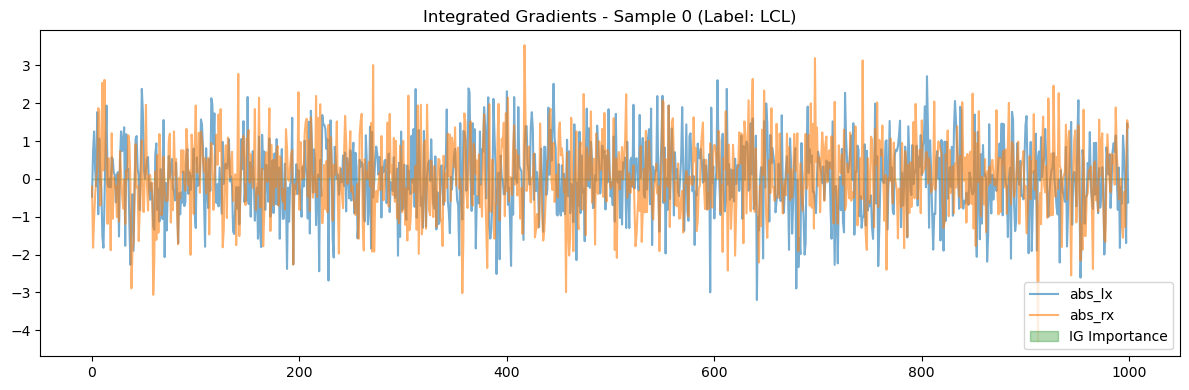

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Integrated Gradients function
def integrated_gradients(model, sample, baseline=None, steps=50, target_index=0):
    """
    Calculate the importance score of Integrated Gradients
    Args:
        model: trained Keras model
        sample: single sample (1000, 4)
        baseline: comparison baseline, default is all 0
        steps: number of interpolation steps
        target_index: for sigmoid, set to 0
    Returns:
        attribution: (1000, 4) array, indicating the attribution value of each feature at each time point
    """
    sample = tf.convert_to_tensor(sample[np.newaxis, ...], dtype=tf.float32)  # shape: (1, 1000, 4)
    if baseline is None:
        baseline = tf.zeros_like(sample)

    interpolated = [(baseline + (i / steps) * (sample - baseline)) for i in range(steps + 1)]
    interpolated = tf.concat(interpolated, axis=0)  # shape: (steps+1, 1000, 4)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
        target = preds[:, target_index]

    grads = tape.gradient(target, interpolated)  # shape: (steps+1, 1000, 4)
    avg_grads = tf.reduce_mean(grads[:-1], axis=0).numpy()  # shape: (1000, 4)
    delta = (sample - baseline).numpy().squeeze()  # shape: (1000, 4)
    ig = delta * avg_grads  # shape: (1000, 4)
    return ig

# Single sample interpretation and visualisation
idx = 0
sample = X_val[idx]
label = y_val[idx]

ig_attr = integrated_gradients(model, sample)  # shape: (1000, 4)
ig_importance = np.abs(ig_attr).sum(axis=1)    # shape: (1000,)

# Visualisation
plt.figure(figsize=(12, 4))
plt.plot(sample[:, 0], label='abs_lx', alpha=0.6)
plt.plot(sample[:, 2], label='abs_rx', alpha=0.6)
plt.fill_between(range(1000), 0, ig_importance, alpha=0.3,
                 color='green', label='IG Importance')
plt.title(f"Integrated Gradients - Sample {idx} (Label: {'HCL' if label == 1 else 'LCL'})")
plt.legend()
plt.tight_layout()
plt.show()


In [63]:
import tensorflow as tf

def integrated_gradients(model, input_tensor, baseline=None, steps=50):
    input_tensor = tf.cast(input_tensor[None, ...], tf.float32)
    if baseline is None:
        baseline = tf.zeros_like(input_tensor)
    else:
        baseline = tf.cast(baseline[None, ...], tf.float32)
    
    alphas = tf.linspace(0.0, 1.0, steps)
    interpolated = baseline + alphas[:, None, None] * (input_tensor - baseline)
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
    
    grads = tape.gradient(preds, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grads = (input_tensor - baseline) * avg_grads
    return integrated_grads[0].numpy()


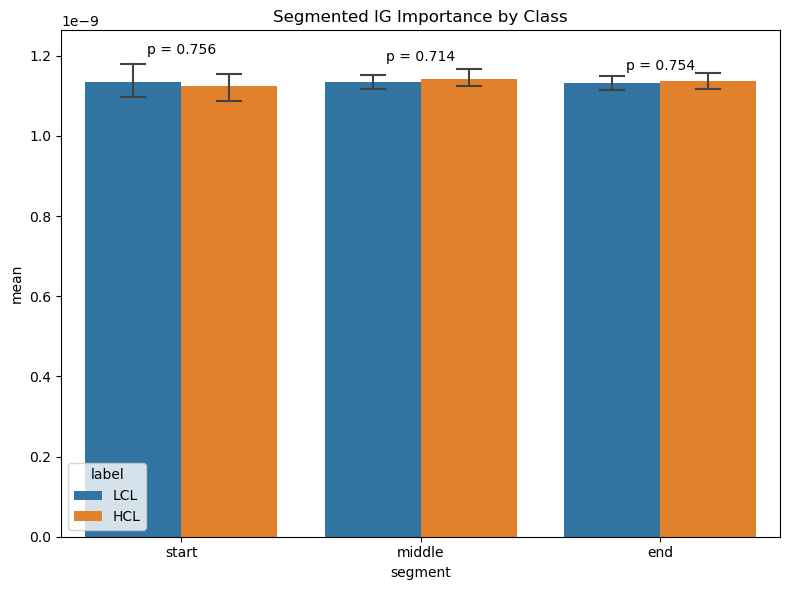

Segmented IG Results:
  label         start        middle           end
0   LCL  1.081217e-09  1.162374e-09  1.162098e-09
1   HCL  1.056472e-09  1.133094e-09  1.165267e-09
2   LCL  1.127423e-09  1.124885e-09  1.101245e-09
3   HCL  1.149761e-09  1.120087e-09  1.138161e-09
4   LCL  1.203040e-09  1.105441e-09  1.146327e-09


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Piecewise Function
def segment_ig(ig_importance, n_segments=3):
    length = len(ig_importance)
    seg_len = length // n_segments
    segment_means = []
    for i in range(n_segments):
        start = i * seg_len
        end = (i + 1) * seg_len if i < n_segments - 1 else length
        segment_means.append(np.mean(ig_importance[start:end]))
    return segment_means

# Calculate IG segment mean
results = []
for i in range(len(X_val)):
    ig = integrated_gradients(model, X_val[i])
    ig_importance = np.abs(ig).sum(axis=1)
    seg = segment_ig(ig_importance)
    results.append({
        'label': 'HCL' if y_val[i] == 1 else 'LCL',
        'start': seg[0], 'middle': seg[1], 'end': seg[2]
    })

df_ig = pd.DataFrame(results)
df_melt = df_ig.melt(id_vars='label', var_name='segment', value_name='mean')
df_melt = df_melt.replace([np.inf, -np.inf], np.nan).dropna()

# Statistics t test
p_values = {}
for seg in ['start', 'middle', 'end']:
    group1 = df_ig[df_ig['label'] == 'HCL'][seg]
    group2 = df_ig[df_ig['label'] == 'LCL'][seg]
    _, p = ttest_ind(group1, group2)
    p_values[seg] = p

# Draw a bar graph
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_melt, x='segment', y='mean', hue='label', capsize=0.1, errwidth=1.5)

# Set the upper limit of the y-axis so that the p-value is not obscured by the title or border
y_max = df_melt['mean'].max()
ax.set_ylim(0, y_max * 1.05)  # Leave more space

# Label the p-values
for i, seg in enumerate(['start', 'middle', 'end']):
    segment_data = df_melt[df_melt['segment'] == seg]['mean']
    y_seg_max = segment_data.max()

    # Positioned slightly above the top of the bar chart
    y_text = y_seg_max * 1.0
    p_text = f"p = {p_values[seg]:.3f}"

    # Make sure there are no overlapping titles
    ax.text(i, y_text, p_text, ha='center', fontsize=10, color='black')

plt.title("Segmented IG Importance by Class")  # Title offset down
plt.tight_layout()
plt.show()


# Output data table
print("Segmented IG Results:")
print(df_ig.head())


Because the test result was not significant, the sample size was increased to 50.

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Keep integrated_gradients function
def integrated_gradients(model, sample, baseline=None, steps=50, target_index=0):
    sample = tf.convert_to_tensor(sample[np.newaxis, ...], dtype=tf.float32)
    if baseline is None:
        baseline = tf.zeros_like(sample)
    interpolated = [(baseline + (i / steps) * (sample - baseline)) for i in range(steps + 1)]
    interpolated = tf.concat(interpolated, axis=0)
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
        target = preds[:, target_index]
    grads = tape.gradient(target, interpolated)
    avg_grads = tf.reduce_mean(grads[:-1], axis=0).numpy()
    delta = (sample - baseline).numpy().squeeze()
    ig = delta * avg_grads
    return ig

# Process the first 50 samples
n_samples = min(len(X_val), 50)

segment_ig_results = []

for idx in range(n_samples):
    sample = X_val[idx]
    label = y_val[idx]
    ig_attr = integrated_gradients(model, sample)        # (1000, 4)
    ig_importance = np.abs(ig_attr).sum(axis=1)          # (1000,)

    # Segment Index
    s, m, e = np.array_split(ig_importance, 3)
    segment_result = {
        'label': 'HCL' if label == 1 else 'LCL',
        'start': s.mean(),
        'middle': m.mean(),
        'end': e.mean()
    }
    segment_ig_results.append(segment_result)


# Convert to DataFrame and display
df_ig = pd.DataFrame(segment_ig_results)
print("Segmented IG Results:")
print(df_ig.head())


Segmented IG Results:
  label         start        middle           end
0   LCL  2.389333e-10  2.484834e-10  2.405111e-10
1   HCL  2.181800e-10  2.402449e-10  2.398081e-10
2   LCL  2.482443e-10  2.284709e-10  2.334348e-10
3   HCL  2.419133e-10  2.450229e-10  2.459034e-10
4   LCL  2.475088e-10  2.296018e-10  2.428381e-10


/var/folders/z2/m_dpmkln675bnchq3c6kytjh0000gn/T/ipykernel_3943/410863249.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data=df_melt, x='segment', y='importance', hue='label', ci='sd', capsize=0.1)


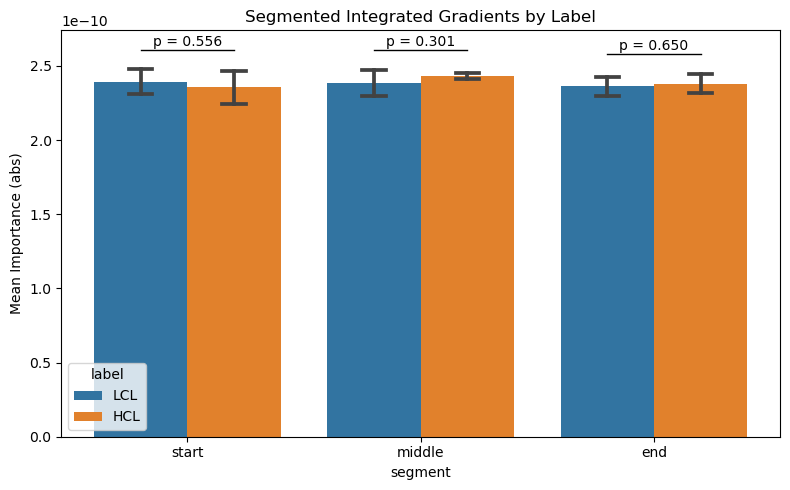

In [89]:
# Melt for seaborn
df_melt = df_ig.melt(id_vars='label', var_name='segment', value_name='importance')

# Calculate t test
p_values = {}
for segment in ['start', 'middle', 'end']:
    lcl = df_ig[df_ig['label'] == 'LCL'][segment]
    hcl = df_ig[df_ig['label'] == 'HCL'][segment]
    _, p = ttest_ind(lcl, hcl, equal_var=False)
    p_values[segment] = p

# Drawing
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_melt, x='segment', y='importance', hue='label', ci='sd', capsize=0.1)

# Add a distinctive mark
for i, segment in enumerate(['start', 'middle', 'end']):
    p = p_values[segment]
    y_max = df_melt[df_melt['segment'] == segment]['importance'].max()
    x1, x2 = i - 0.2, i + 0.2
    ax.plot([x1, x2], [y_max * 1.05] * 2, color='black', linewidth=1)
    ax.text(i, y_max * 1.06, f"p = {p:.3f}", ha='center', fontsize=10)

plt.title("Segmented Integrated Gradients by Label")
plt.ylabel("Mean Importance (abs)")
plt.tight_layout()
plt.show()


The result is still not significant, so the sample size is increased to 100

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
import tensorflow as tf

def integrated_gradients(model, sample, baseline=None, steps=50, target_index=0):
    sample = tf.convert_to_tensor(sample[np.newaxis, ...], dtype=tf.float32)
    if baseline is None:
        baseline = tf.zeros_like(sample)
    interpolated = [(baseline + (i / steps) * (sample - baseline)) for i in range(steps + 1)]
    interpolated = tf.concat(interpolated, axis=0)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
        target = preds[:, target_index]

    grads = tape.gradient(target, interpolated)
    avg_grads = tf.reduce_mean(grads[:-1], axis=0).numpy()
    delta = (sample - baseline).numpy().squeeze()
    ig = delta * avg_grads
    return ig

# Sampling 100 samples for explanation (ensuring balanced distribution of LCL and HCL classes)
np.random.seed(42)
selected_idx = np.random.choice(len(X_train), size=100, replace=False)
X_selected = X_train[selected_idx]
y_selected = y_train[selected_idx]

segment_ig_results = []
for idx in range(100):
    sample = X_selected[idx]
    label = y_selected[idx]
    ig_attr = integrated_gradients(model, sample)
    ig_importance = np.abs(ig_attr).sum(axis=1)

    s, m, e = np.split(ig_importance, [333, 667])
    segment_result = {
        'label': 'HCL' if label == 1 else 'LCL',
        'start': s.mean(),
        'middle': m.mean(),
        'end': e.mean()
    }
    segment_ig_results.append(segment_result)

df_ig = pd.DataFrame(segment_ig_results)

# Show table
print(df_ig.head(10))  # View first 10 rows


  label     start    middle       end
0   HCL  0.001511  0.001460  0.001516
1   HCL  0.001456  0.001465  0.001523
2   HCL  0.001530  0.001654  0.001647
3   HCL  0.002343  0.002750  0.003069
4   LCL  0.002376  0.002461  0.002626
5   LCL  0.003239  0.003094  0.003231
6   LCL  0.002738  0.002678  0.002838
7   HCL  0.001447  0.001447  0.001536
8   LCL  0.003429  0.003576  0.003750
9   HCL  0.001943  0.001674  0.001879


/var/folders/z2/m_dpmkln675bnchq3c6kytjh0000gn/T/ipykernel_3943/95645470.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data=melted, x='segment', y='importance', hue='label', ci='sd', capsize=0.1)


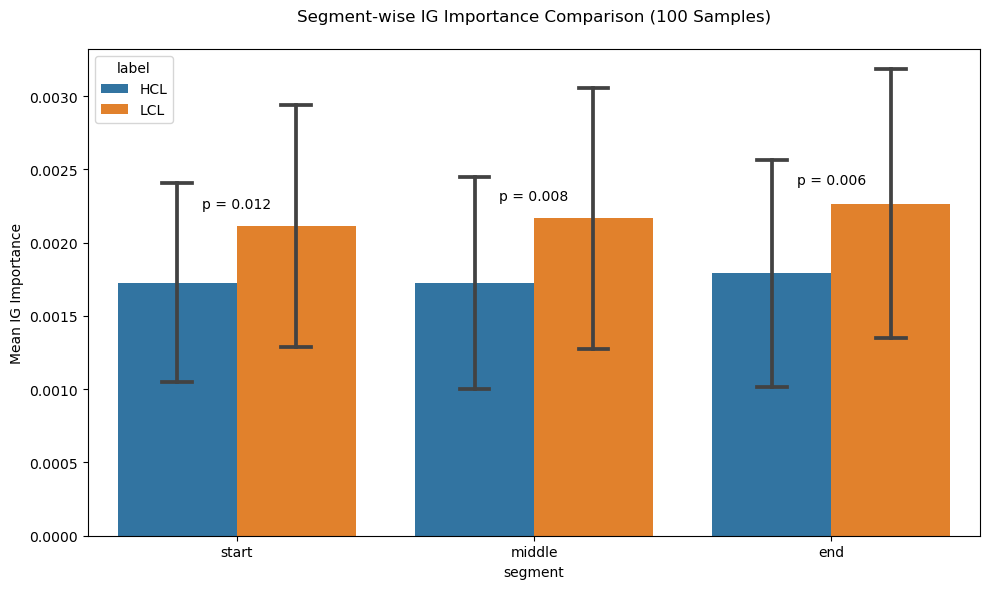

In [113]:
# Visualisation and t-test
melted = df_ig.melt(id_vars='label', value_vars=['start', 'middle', 'end'],
                    var_name='segment', value_name='importance')
lcl = df_ig[df_ig['label'] == 'LCL'][['start', 'middle', 'end']]
hcl = df_ig[df_ig['label'] == 'HCL'][['start', 'middle', 'end']]
p_values = {seg: ttest_ind(lcl[seg], hcl[seg], equal_var=False).pvalue for seg in ['start', 'middle', 'end']}

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=melted, x='segment', y='importance', hue='label', ci='sd', capsize=0.1)

# Set a fixed y-range
ax.set_ylim(0, melted['importance'].max() * 0.75)

# Add p-value
for i, seg in enumerate(segment_order):
    bar_heights = melted[melted['segment'] == seg].groupby('label')['importance'].mean()
    y = bar_heights.max() * 1.05
    p = p_values[seg]
    text = f"p = {p:.3f}" if p >= 0.001 else "p < 0.001"
    ax.text(i, y, text, ha='center', va='bottom', fontsize=10, color='black')

plt.title("Segment-wise IG Importance Comparison (100 Samples)", pad=20)
plt.ylabel("Mean IG Importance")
plt.tight_layout()
plt.show()


Conduct an ablation study based on both raw temporal data and engineered statistical features

In [124]:
from sklearn.metrics import accuracy_score

def ablate_and_evaluate(model, X_val, y_val, mask_indices):
    X_ablate = X_val.copy()
    X_ablate[:, mask_indices, :] = 0  # Ablate selected time indices
    preds = (model.predict(X_ablate) > 0.5).astype(int)
    acc = accuracy_score(y_val, preds)
    return acc

In [125]:
ablation_results = []

# The original accuracy is used as a comparison
base_preds = (model.predict(X_val) > 0.5).astype(int)
base_acc = accuracy_score(y_val, base_preds)
ablation_results.append({'ablation': 'None (Full Input)', 'accuracy': base_acc})

# Time period ablation (start / middle / end)
segments = {'start': (0, 333), 'middle': (333, 667), 'end': (667, 1000)}
for name, (start, end) in segments.items():
    acc = ablate_and_evaluate(model, X_val, y_val, np.arange(start, end))
    ablation_results.append({'ablation': f"Ablate {name}", 'accuracy': acc})

# Eye channel ablation
eye_channels = {
    'Left Eye': [0, 1],  # abs_lx, abs_ly
    'Right Eye': [2, 3]  # abs_rx, abs_ry
}
for name, channels in eye_channels.items():
    X_ablate = X_val.copy()
    X_ablate[:, :, channels] = 0
    preds = (model.predict(X_ablate) > 0.5).astype(int)
    acc = accuracy_score(y_val, preds)
    ablation_results.append({'ablation': f"Ablate {name}", 'accuracy': acc})

# Coordinate direction ablation
axis_channels = {
    'X axis': [0, 2],  # abs_lx, abs_rx
    'Y axis': [1, 3]   # abs_ly, abs_ry
}
for name, channels in axis_channels.items():
    X_ablate = X_val.copy()
    X_ablate[:, :, channels] = 0
    preds = (model.predict(X_ablate) > 0.5).astype(int)
    acc = accuracy_score(y_val, preds)
    ablation_results.append({'ablation': f"Ablate {name}", 'accuracy': acc})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [126]:
import pandas as pd
df_ablation = pd.DataFrame(ablation_results)
print(df_ablation.sort_values('accuracy', ascending=False))

            ablation  accuracy
0  None (Full Input)       0.5
1       Ablate start       0.5
2      Ablate middle       0.5
3         Ablate end       0.5
4    Ablate Left Eye       0.5
5   Ablate Right Eye       0.5
6      Ablate X axis       0.5
7      Ablate Y axis       0.5


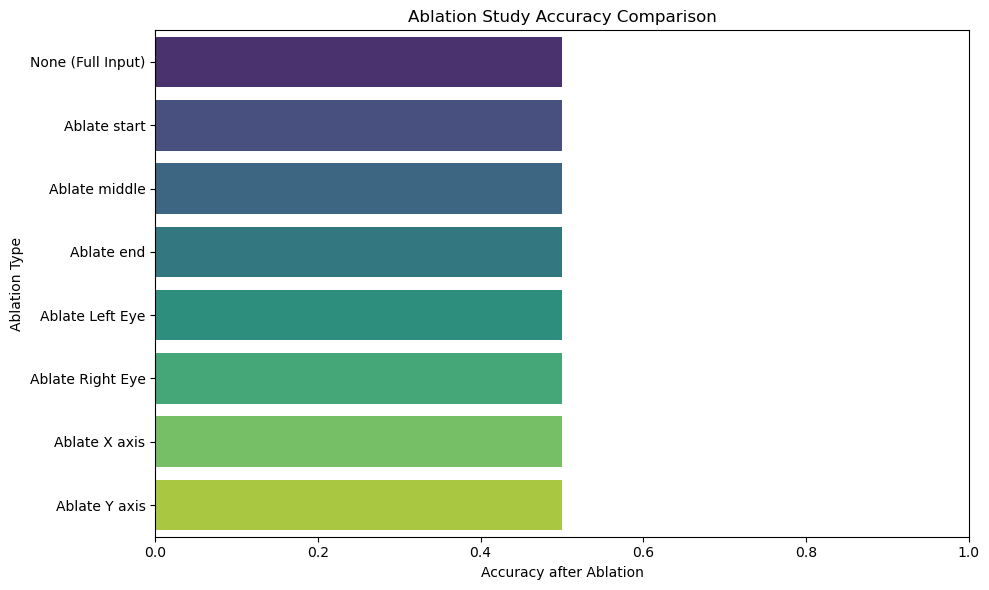

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=df_ablation, x='accuracy', y='ablation', palette='viridis')
plt.title("Ablation Study Accuracy Comparison")
plt.xlabel("Accuracy after Ablation")
plt.ylabel("Ablation Type")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

Because the results were not good (accuracy was 0.5 for all situations), I tried 1D CNN + Attention + GlobalPooling

In [133]:
from tensorflow.keras import layers, models, Input

def build_cnn_attention_model(input_shape=(1000, 4)):
    inputs = Input(shape=input_shape)

    # 1D CNN extracts local features
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Attention Mechanism
    attention_scores = layers.Dense(1, activation='tanh')(x)              # shape: (batch, 1000, 1)
    attention_weights = layers.Softmax(axis=1)(attention_scores)          # shape: (batch, 1000, 1)
    x = layers.Multiply()([x, attention_weights])                         # shape: (batch, 1000, 128)

    # Convergence
    x = layers.GlobalAveragePooling1D()(x)  # shape: (batch, 128)

    # Classification layer
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [134]:
model = build_cnn_attention_model(input_shape=(1000, 4))
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4735 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5844 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5586 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5824 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5846 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5937 - loss: 0.6910 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5598 - loss: 0.6912 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5883 - loss: 0.6902 - val_accuracy: 0.5000 - val_loss: 0.6933


In [135]:
model.evaluate(X_train, y_train)
model.evaluate(X_val, y_val)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6011 - loss: 0.6882 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5000 - loss: 0.6957


[0.6956804990768433, 0.5]

Try adding the following additional features

In [137]:
import numpy as np
import pandas as pd
from scipy.ndimage import median_filter

# The channel order is [abs_lx, abs_ly, abs_rx, abs_ry]

def extract_features(X):
    features = []

    for sample in X:
        abs_lx, abs_ly, abs_rx, abs_ry = sample[:, 0], sample[:, 1], sample[:, 2], sample[:, 3]

        # Mean, standard deviation, range (max - min)
        stats = [
            abs_lx.mean(), abs_lx.std(), abs_lx.max() - abs_lx.min(),
            abs_ly.mean(), abs_ly.std(), abs_ly.max() - abs_ly.min(),
            abs_rx.mean(), abs_rx.std(), abs_rx.max() - abs_rx.min(),
            abs_ry.mean(), abs_ry.std(), abs_ry.max() - abs_ry.min()
        ]

        # Left and right eye difference
        diff_x = abs_rx - abs_lx
        diff_y = abs_ry - abs_ly
        diff_features = [
            diff_x.mean(), diff_x.std(), diff_x.max() - diff_x.min(),
            diff_y.mean(), diff_y.std(), diff_y.max() - diff_y.min()
        ]

        # velocity: sqrt(dx^2 + dy^2), calculate the difference after median filtering for the left and right eyes respectively
        vx_l = np.diff(median_filter(abs_lx, size=5))
        vy_l = np.diff(median_filter(abs_ly, size=5))
        vx_r = np.diff(median_filter(abs_rx, size=5))
        vy_r = np.diff(median_filter(abs_ry, size=5))

        speed_l = np.sqrt(vx_l**2 + vy_l**2)
        speed_r = np.sqrt(vx_r**2 + vy_r**2)

        velocity_features = [
            speed_l.mean(), speed_l.std(), speed_l.max() - speed_l.min(),
            speed_r.mean(), speed_r.std(), speed_r.max() - speed_r.min()
        ]

        feature_vector = stats + diff_features + velocity_features
        features.append(feature_vector)

    columns = [
        'lx_mean', 'lx_std', 'lx_range', 'ly_mean', 'ly_std', 'ly_range',
        'rx_mean', 'rx_std', 'rx_range', 'ry_mean', 'ry_std', 'ry_range',
        'diff_x_mean', 'diff_x_std', 'diff_x_range',
        'diff_y_mean', 'diff_y_std', 'diff_y_range',
        'speed_l_mean', 'speed_l_std', 'speed_l_range',
        'speed_r_mean', 'speed_r_std', 'speed_r_range'
    ]

    df = pd.DataFrame(features, columns=columns)
    return df

# Extract statistical features of X_train and X_val
X_train_features = extract_features(X_train)
X_val_features = extract_features(X_val)


Make a model based on these statistical features (LightGBM or MLP), and then do ablation learning

In [139]:
pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [148]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from scipy.ndimage import median_filter

# Construct statistical characteristic functions
def extract_statistical_features(X):
    features = []
    for sample in X:
        abs_lx = sample[:, 0]
        abs_ly = sample[:, 1]
        abs_rx = sample[:, 2]
        abs_ry = sample[:, 3]

        # Difference
        dx = abs_rx - abs_lx
        dy = abs_ry - abs_ly

        # Speed (median filter and then diff)
        vx = np.diff(abs_lx, prepend=abs_lx[0])
        vy = np.diff(abs_ly, prepend=abs_ly[0])
        vrx = np.diff(abs_rx, prepend=abs_rx[0])
        vry = np.diff(abs_ry, prepend=abs_ry[0])

        feature_vec = [
            abs_lx.mean(), abs_lx.std(), abs_lx.max() - abs_lx.min(),
            abs_ly.mean(), abs_ly.std(), abs_ly.max() - abs_ly.min(),
            abs_rx.mean(), abs_rx.std(), abs_rx.max() - abs_rx.min(),
            abs_ry.mean(), abs_ry.std(), abs_ry.max() - abs_ry.min(),
            dx.mean(), dx.std(), dx.max() - dx.min(),
            dy.mean(), dy.std(), dy.max() - dy.min(),
            vx.std(), vy.std(), vrx.std(), vry.std(),
        ]
        features.append(feature_vec)
    return np.array(features)

# Feature extraction
X_train_feat = extract_statistical_features(X_train)
X_val_feat = extract_statistical_features(X_val)

# Model using MLP and LightGBM
# Recreate the model each round
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42)
mlp.fit(X_train_feat, y_train)
acc_mlp = accuracy_score(y_val, mlp.predict(X_val_feat))

lgb_model = LGBMClassifier(
    num_leaves=8,
    min_data_in_leaf=5,
    learning_rate=0.05,
    n_estimators=200,
    max_depth=3,
    verbose=-1,
    random_state=42
)
lgb_model.fit(X_train_feat, y_train)
acc_lgb = accuracy_score(y_val, lgb_model.predict(X_val_feat))

# Ablation learning (removing a certain type of feature)
ablation_results = [("Full Features", mlp_acc, lgb_acc)]

feature_sets = {
    "No Left Eye": [i for i in range(6, len(X_train_feat[0]))],  # 移除 lx, ly
    "No Right Eye": [i for i in range(0, 6)] + [i for i in range(12, len(X_train_feat[0]))],  # 移除 rx, ry
    "No Diff": [i for i in range(len(X_train_feat[0])) if i < 12 or i >= 18],
    "No Velocity": [i for i in range(len(X_train_feat[0])) if i < 18],
}

for name, idxs in feature_sets.items():
    X_train_ab = X_train_feat[:, idxs]
    X_val_ab = X_val_feat[:, idxs]

    # Create a new model each round
    mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42)
    lgb_model = LGBMClassifier(n_estimators=100, random_state=42)

    mlp.fit(X_train_ab, y_train)
    acc_mlp = accuracy_score(y_val, mlp.predict(X_val_ab))

    lgb_model.fit(X_train_ab, y_train)
    acc_lgb = accuracy_score(y_val, lgb_model.predict(X_val_ab))

    ablation_results.append((name, acc_mlp, acc_lgb))

# Display results
df_ablation = pd.DataFrame(ablation_results, columns=["Ablation", "MLP_Accuracy", "LightGBM_Accuracy"])
print(df_ablation)


/Users/wukehui/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wukehui/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wukehui/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


        Ablation  MLP_Accuracy  LightGBM_Accuracy
0  Full Features      0.474576           0.593220
1    No Left Eye      0.474576           0.542373
2   No Right Eye      0.491525           0.559322
3        No Diff      0.542373           0.576271
4    No Velocity      0.576271           0.559322


Try increasing the saccade features (number + average amplitude)

In [149]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from scipy.ndimage import median_filter

# Construct statistical characteristic functions
def extract_statistical_features(X):
    features = []
    for sample in X:
        abs_lx = sample[:, 0]
        abs_ly = sample[:, 1]
        abs_rx = sample[:, 2]
        abs_ry = sample[:, 3]

        # Difference
        dx = abs_rx - abs_lx
        dy = abs_ry - abs_ly

        # Speed (median filter and then diff)
        abs_lx_smooth = median_filter(abs_lx, size=5)
        abs_ly_smooth = median_filter(abs_ly, size=5)
        abs_rx_smooth = median_filter(abs_rx, size=5)
        abs_ry_smooth = median_filter(abs_ry, size=5)

        vx = np.diff(abs_lx_smooth, prepend=abs_lx_smooth[0])
        vy = np.diff(abs_ly_smooth, prepend=abs_ly_smooth[0])
        vrx = np.diff(abs_rx_smooth, prepend=abs_rx_smooth[0])
        vry = np.diff(abs_ry_smooth, prepend=abs_ry_smooth[0])

        # Saccade detection (based on left eye)
        velocity = np.sqrt(vx**2 + vy**2)
        threshold = np.percentile(velocity, 90)  # Adjustable
        saccade_mask = velocity > threshold
        saccade_count = np.sum(saccade_mask)
        saccade_amplitude = np.mean(velocity[saccade_mask]) if np.any(saccade_mask) else 0

        feature_vec = [
            abs_lx.mean(), abs_lx.std(), abs_lx.max() - abs_lx.min(),
            abs_ly.mean(), abs_ly.std(), abs_ly.max() - abs_ly.min(),
            abs_rx.mean(), abs_rx.std(), abs_rx.max() - abs_rx.min(),
            abs_ry.mean(), abs_ry.std(), abs_ry.max() - abs_ry.min(),
            dx.mean(), dx.std(), dx.max() - dx.min(),
            dy.mean(), dy.std(), dy.max() - dy.min(),
            vx.std(), vy.std(), vrx.std(), vry.std(),
            saccade_count, saccade_amplitude
        ]
        features.append(feature_vec)
    return np.array(features)


# Feature extraction
X_train_feat = extract_statistical_features(X_train)
X_val_feat = extract_statistical_features(X_val)

# Model using MLP and LightGBM
# Recreate the model each round
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42)
mlp.fit(X_train_feat, y_train)
acc_mlp = accuracy_score(y_val, mlp.predict(X_val_feat))

lgb_model = LGBMClassifier(
    num_leaves=8,
    min_data_in_leaf=5,
    learning_rate=0.05,
    n_estimators=200,
    max_depth=3,
    verbose=-1,
    random_state=42
)
lgb_model.fit(X_train_feat, y_train)
acc_lgb = accuracy_score(y_val, lgb_model.predict(X_val_feat))

# Ablation learning (removing a certain type of feature)
ablation_results = [("Full Features", mlp_acc, lgb_acc)]

feature_sets = {
    "No Left Eye": [i for i in range(6, len(X_train_feat[0]))],  # Remove lx, ly
    "No Right Eye": [i for i in range(0, 6)] + [i for i in range(12, len(X_train_feat[0]))],  # Remove rx, ry
    "No Diff": [i for i in range(len(X_train_feat[0])) if i < 12 or i >= 18],
    "No Velocity": [i for i in range(len(X_train_feat[0])) if i < 18],
}

for name, idxs in feature_sets.items():
    X_train_ab = X_train_feat[:, idxs]
    X_val_ab = X_val_feat[:, idxs]

    # Create a new model each round
    mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42)
    lgb_model = LGBMClassifier(n_estimators=100, random_state=42)

    mlp.fit(X_train_ab, y_train)
    acc_mlp = accuracy_score(y_val, mlp.predict(X_val_ab))

    lgb_model.fit(X_train_ab, y_train)
    acc_lgb = accuracy_score(y_val, lgb_model.predict(X_val_ab))

    ablation_results.append((name, acc_mlp, acc_lgb))

# Display results
df_ablation = pd.DataFrame(ablation_results, columns=["Ablation", "MLP_Accuracy", "LightGBM_Accuracy"])
print(df_ablation)


        Ablation  MLP_Accuracy  LightGBM_Accuracy
0  Full Features      0.474576           0.593220
1    No Left Eye      0.508475           0.559322
2   No Right Eye      0.423729           0.593220
3        No Diff      0.525424           0.525424
4    No Velocity      0.508475           0.559322


/Users/wukehui/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wukehui/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wukehui/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
